In [1]:
%reload_kedro
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

2021-06-17 14:30:23,704 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.


/home/chmony/Apps/anaconda3/envs/foehnfirecorrplot/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2021-06-17 14:30:23,952 - root - INFO - ** Kedro project Foehn fire impact
2021-06-17 14:30:23,953 - root - INFO - Defined global variable `context`, `session` and `catalog`
2021-06-17 14:30:23,961 - root - INFO - Registered line magic `run_viz`


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sci
from modelling_utils import *
import kedro.framework.context
import os

plt.rcParams["figure.figsize"] = (16,9)
sns.set(font_scale=1.6)
sns.set_style("whitegrid")

# Load data

In [4]:
df_indices = context.catalog.load("fire_indices_data")
df_indices.columns

2021-06-17 14:30:26,010 - kedro.io.data_catalog - INFO - Loading data from `fire_indices_data` (CSVDataSet)...


Index(['date', 'gh', 'gcs', 'eta.etp.S', 'eta.etp.C', 'T', 'Tmax', 'Tmin',
       'Tdew', 'Tdew12', 'Tdew15', 'H', 'U', 'P', 'PDur', 'SnowCover',
       'RobiniaBlossom', 'BirchLeaves', 'PC', 'N', 'DaysSinceRain',
       'AgeRainEvent_2_20', 'WeekRain', 'RainSum', 'lastRainSum',
       'lastRainSum_2_20', 'VPD', 'VPD12', 'VPD13', 'Angstroem', 'Nesterov',
       'Munger', 'EMC', 'FFWI', 'FFWImod', 'KBDI', 'KBDISI', 'Sharples', 'FMI',
       'Baumgartner', 'BaumgartnerDanger', 'NetRad', 'PETpen', 'PETthorn',
       'PETthorn_camargo', 'PETthorn_pereira', 'r', 'OrieuxDanger', 'rs',
       'I87', 'M68', 'pM68', 'M68dwd', 'pM68dwd', 'FFDI', 'DFnoble',
       'DFgriffith', 'DFgriffithAdj', 'FWI', 'ISI', 'BUI', 'FFMC', 'DMC', 'DC',
       'Ifa', 'abbreviation', 'region', 'SnowCoverOrig', 'Ra', 'Rs_fromT',
       'res', 'res_surf', 'FWI_lat', 'BUI_lat', 'DMC_lat', 'DC_lat',
       'Risico_dffm', 'IREPI'],
      dtype='object')

In [5]:
indice_cols_to_keep = ["date", "abbreviation", "region", 
                       "T", "Tmax", "Tmin", "H", "U", "P", "DaysSinceRain", 
                       "VPD", "Angstroem", "Nesterov", "FFWI", "Baumgartner", "OrieuxDanger", "FWI", "DMC", "DC"]

# Load and preprocess fire data

In [6]:
df_fires = context.catalog.load("fire_data_with_foehn_and_control_variables")
df_fires["date"] = df_fires["start_date_min"].dt.date.astype(np.datetime64)
df_fires = df_fires.rename(columns={"closest_station": "abbreviation", "total [ha]": "burned_area", "slope [%]": "slope", "altitude [m asl]": "altitude"})
df_fires["foehn"] = df_fires["foehn_minutes_during_6_hours_after_start_of_fire"] > 0

2021-06-17 14:30:30,136 - kedro.io.data_catalog - INFO - Loading data from `fire_data_with_foehn_and_control_variables` (CSVDataSet)...


In [7]:
fire_cols_to_keep = ["date", "abbreviation", "altitude", "exposition", "slope", "burned_area", "foehn",
                     "duration_min", "duration_max",
                     "foehn_minutes_48_hour_before", "foehn_minutes_24_hour_before", 
                     "foehn_minutes_during_2_hours_after_start_of_fire", "foehn_minutes_during_6_hours_after_start_of_fire", "foehn_minutes_during_12_hours_after_start_of_fire",
                     "FFX_mean_during_2_hours_after_start_of_fire", "FFX_mean_during_6_hours_after_start_of_fire", "FFX_mean_during_12_hours_after_start_of_fire",
                     "FFX_q75_during_2_hours_after_start_of_fire", "FFX_q75_during_6_hours_after_start_of_fire", "FFX_q75_during_12_hours_after_start_of_fire",
                     "FF_mean_during_6_hours_after_start_of_fire",  "FF_mean_during_12_hours_after_start_of_fire", 
                     "fire_regime", "potential_foehn_species", "decade"]

# Burned area prediction model

In [77]:
df_BA = pd.merge(df_fires[fire_cols_to_keep], df_indices[indice_cols_to_keep], on = ["date", "abbreviation"], how="left").dropna(subset=["burned_area"])
df_BA = df_BA.loc[df_BA["region"] == "southern_switzerland", :].reset_index(drop=True)
df_BA["burned_area"] = np.log10(df_BA["burned_area"])
#df_BA["burned_area"].hist()

In [78]:
final_features = ["T",  "H", "U", "P", "DaysSinceRain", 
                  "FFWI", "Baumgartner", "OrieuxDanger", "FWI", 
                  ]

foehn_features = ["foehn_minutes_48_hour_before", "foehn_minutes_24_hour_before", "foehn",
                     "foehn_minutes_during_2_hours_after_start_of_fire", "foehn_minutes_during_6_hours_after_start_of_fire", "foehn_minutes_during_12_hours_after_start_of_fire",
                     #"FFX_mean_during_2_hours_after_start_of_fire", "FFX_mean_during_6_hours_after_start_of_fire", "FFX_mean_during_12_hours_after_start_of_fire",
                     "FFX_q75_during_2_hours_after_start_of_fire", "FFX_q75_during_6_hours_after_start_of_fire", "FFX_q75_during_12_hours_after_start_of_fire",
                     #"FF_mean_during_6_hours_after_start_of_fire",  "FF_mean_during_12_hours_after_start_of_fire"
                 ]

final_features += foehn_features

# Investigate FWI the day before

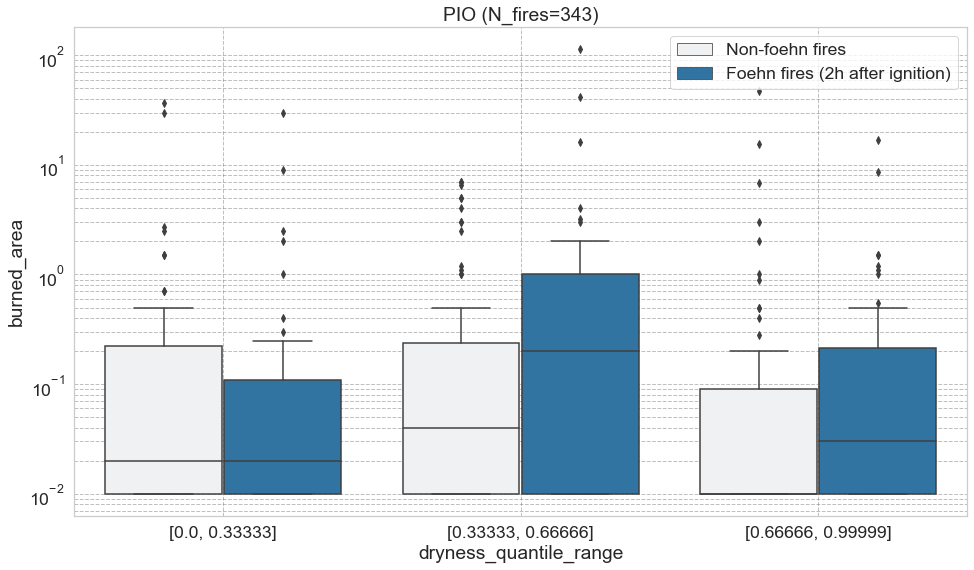

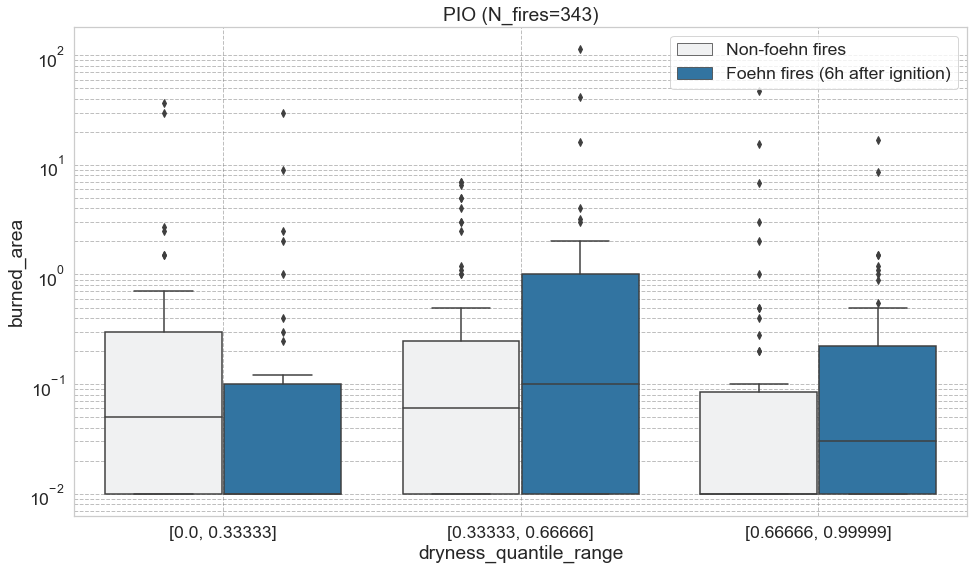

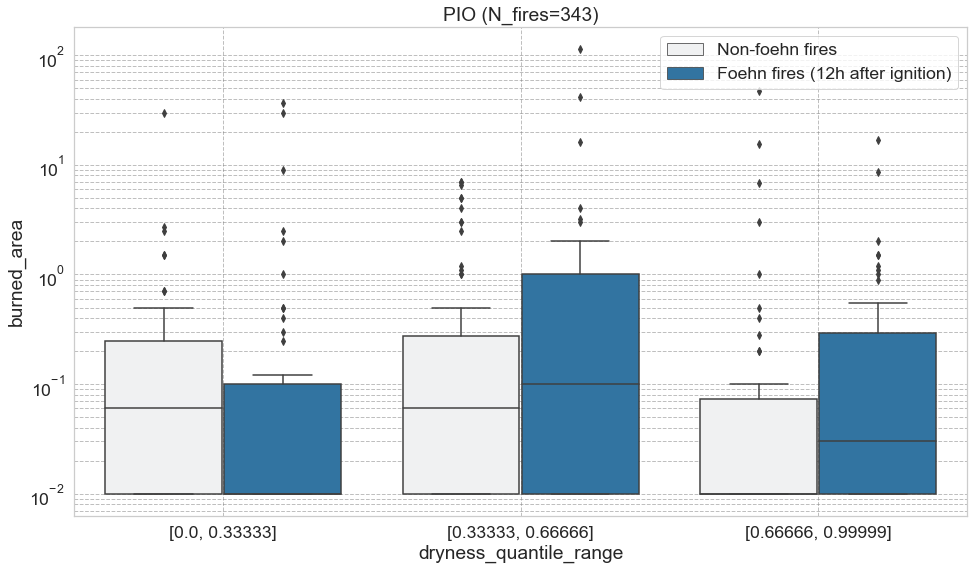

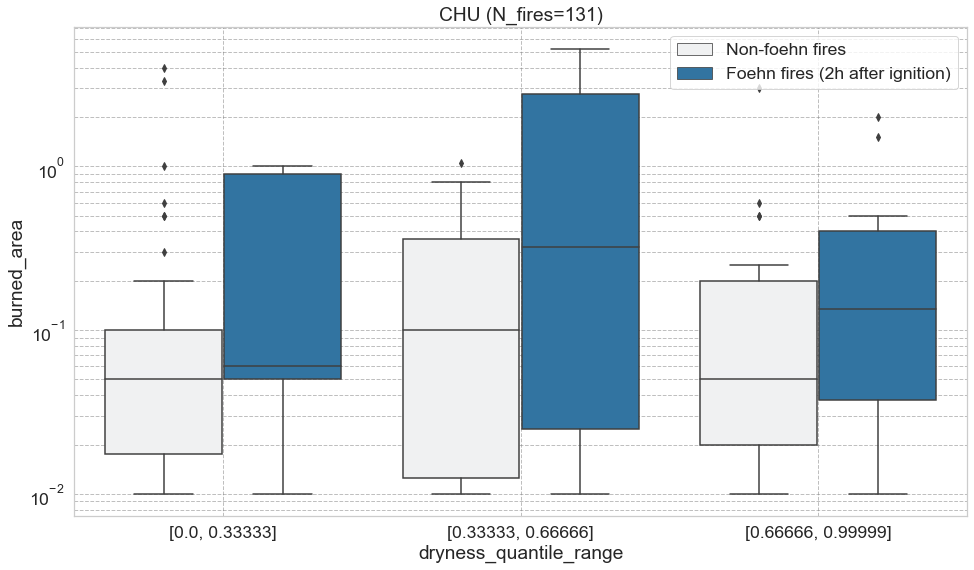

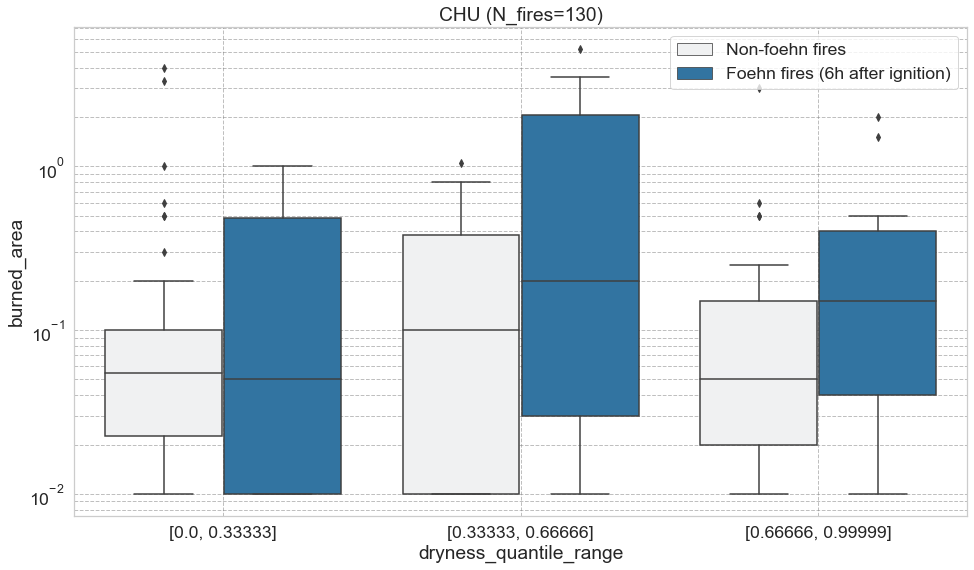

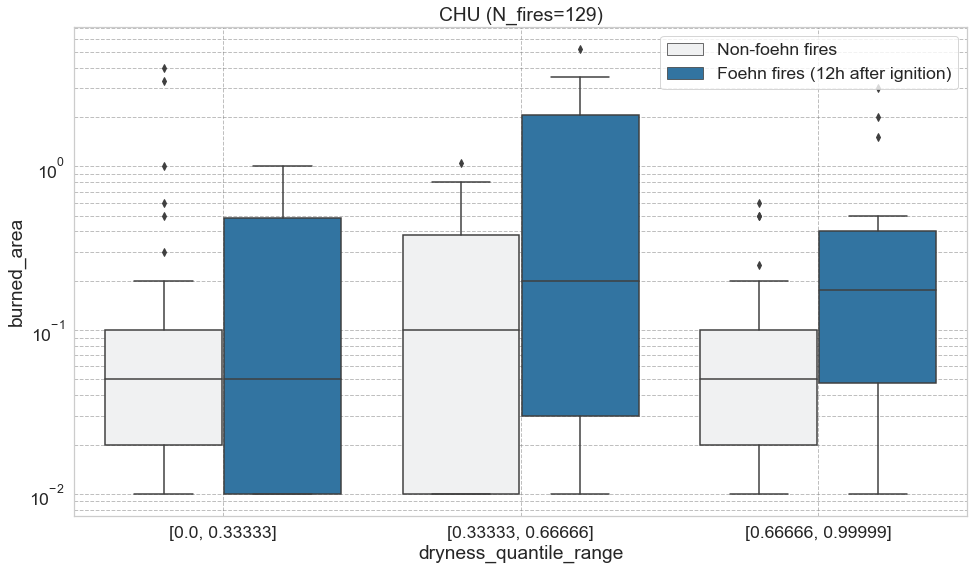

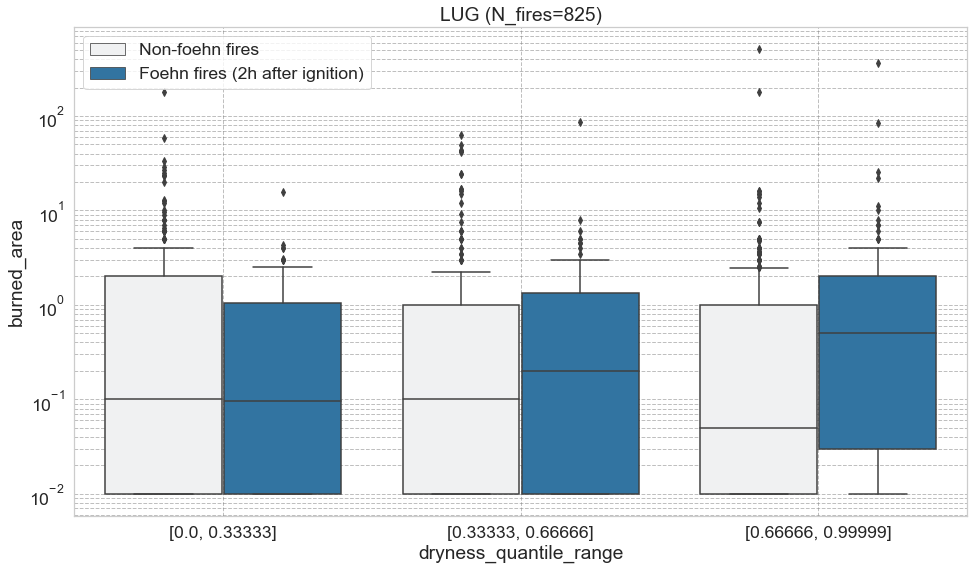

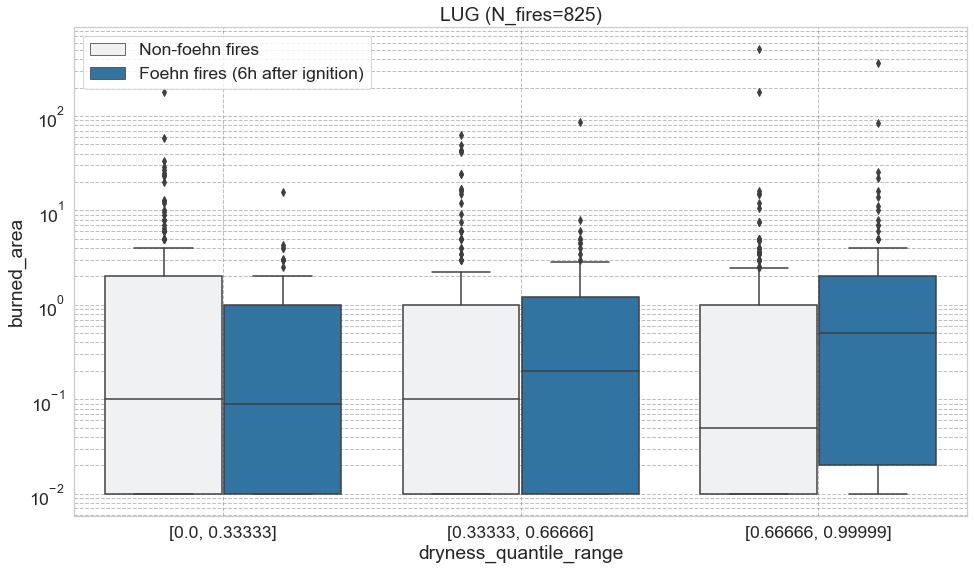

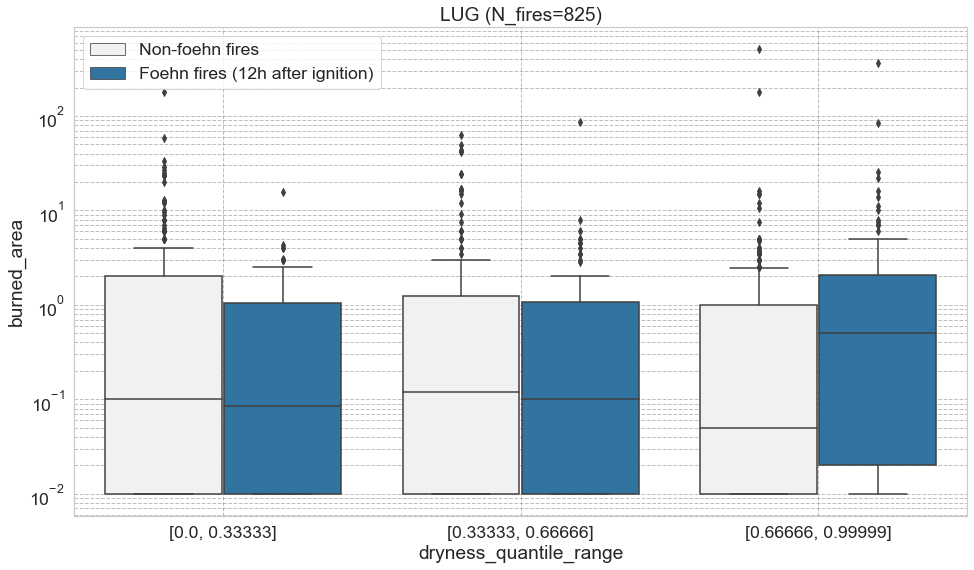

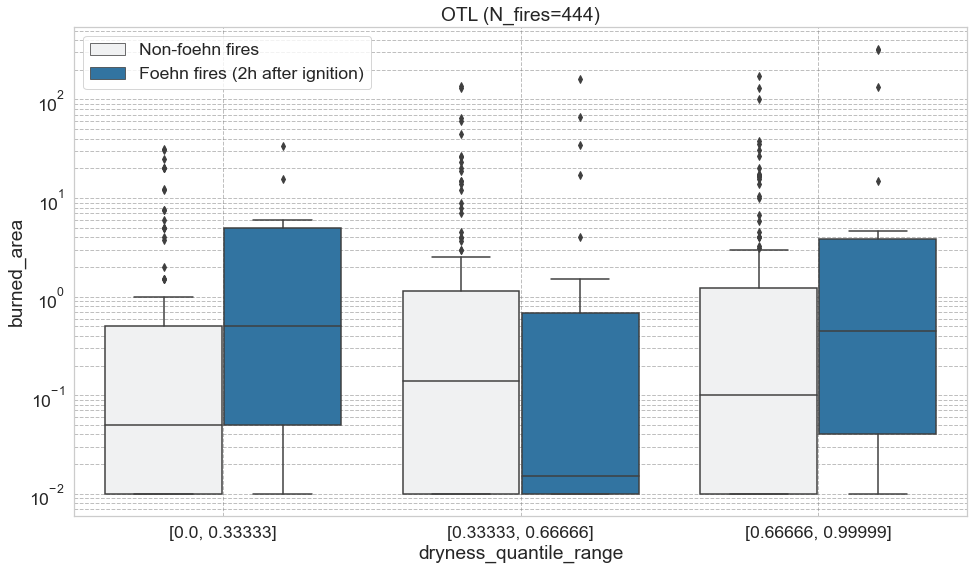

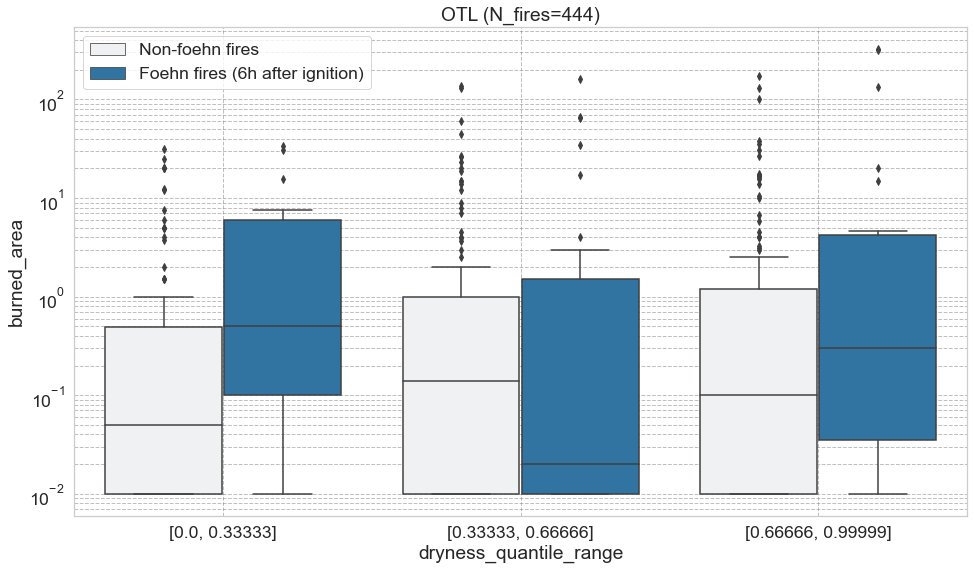

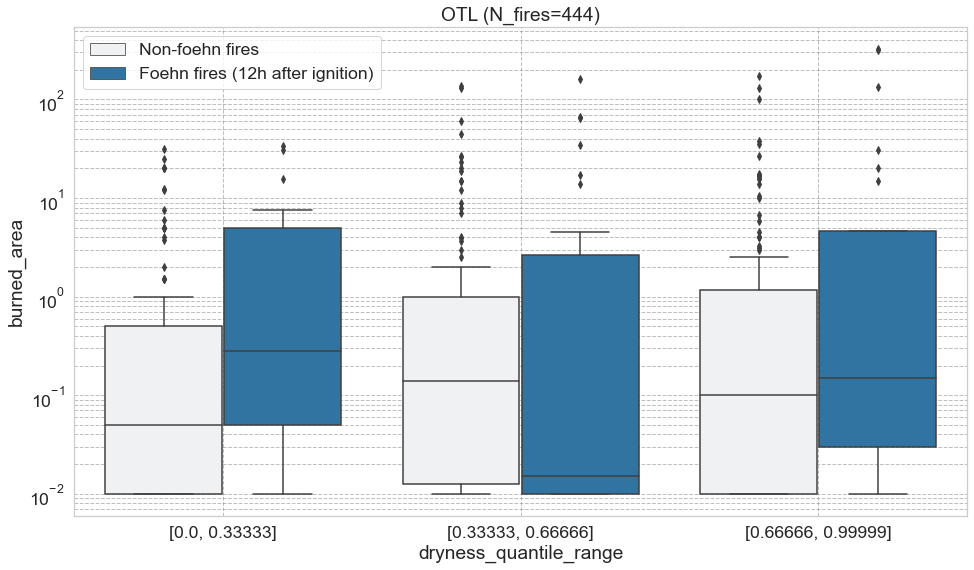

In [8]:
rows_list = []

step_size = 0.33333
quantiles = np.arange(0,0.999, step_size)
for station in (set(df_fires["abbreviation"].unique())- {"ROB"}):
    #print(station)
    
    if (df_indices["abbreviation"]==station).sum() == 0:
        continue
    
    df_local_indices = df_indices.loc[df_indices["abbreviation"]==station, :].set_index("date", verify_integrity=True)
    df_local_indices["FWI_day_before"] = df_local_indices["FWI"].shift(periods=1, freq="D")
   
    df_local_fires = df_fires.loc[df_fires["abbreviation"]==station, :].set_index("date")
    
    if len(df_local_fires.index) < 100:
        continue
    
    df_local = df_local_fires.join(df_local_indices["FWI_day_before"], how="inner")
    
    hue_order = []
    for i, p in enumerate(quantiles):
        hue_order.append(f"[{p}, {p+step_size}]")
        df_local.loc[df_local["FWI_day_before"]>df_local["FWI_day_before"].quantile(p), "dryness_quantile_range"] = f"[{p}, {p+step_size}]"
        
    for hours in [2, 6, 12]:
        foehn_variable = f"foehn_minutes_during_{hours}_hours_after_start_of_fire"
        df_local_foehn = df_local.dropna(subset=[foehn_variable, "FWI_day_before"]).reset_index(drop=True)
        plt.figure()
        df_local_foehn.loc[:, f"{foehn_variable}_cut"] = pd.cut(df_local_foehn.loc[:, foehn_variable], bins=[-0.001, 0.001, hours*60])
        g = sns.boxplot(hue=f"{foehn_variable}_cut", y="burned_area", data=df_local_foehn, x="dryness_quantile_range", order=hue_order, color="tab:blue")
        g.set_yscale("log")
        plt.grid(True, which="both", ls="--", c='gray', alpha=0.5)
        plt.title(f"{station} (N_fires={len(df_local_foehn.index)})")
        L = plt.legend()
        L.get_texts()[0].set_text('Non-foehn fires')
        L.get_texts()[1].set_text(f'Foehn fires ({hours}h after ignition)')
        
        #sns.lmplot(x=foehn_variable, y="burned_area", data=df_local_foehn, col="dry_day")

#         for i, p in enumerate(percentiles):
#             df_dry = df_local_foehn.loc[df_local_foehn["dry_day"]==i, :]
#             slope_dict = {"station": station, "foehn_variable": foehn_variable, "N_fires": len(df_dry.index)}
#             slope, intercept, _, _, _  = scipy.stats.linregress(x=df_dry[foehn_variable], y=df_dry["burned_area"])
#             slope_dict["percentile"] = str(int(p*100))
#             slope_dict["slope"] = slope

#             rows_list.append(slope_dict)

# df_slopes = pd.DataFrame(rows_list)
# display(df_slopes)
# sns.scatterplot(data=df_slopes, x="percentile", y="slope", hue="station")

In [122]:
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import train_test_split


from sklearn.model_selection import GridSearchCV
import mlflow
import causalnex

In [51]:
mlflow.set_experiment("burned_area_model")

In [80]:
test_size = 0.25
#df_BA = df_BA.dropna()
X_train, X_test, y_train, y_test = train_test_split(df_BA[final_features], df_BA["burned_area"], shuffle=True, test_size=test_size, random_state=42)
#mlflow.log_param("test_size", test_size)
#mlflow.log_param("features", X_train.columns.tolist())

In [23]:
X_train.isnull().sum()

T                                                      0
H                                                      0
U                                                      0
P                                                      0
DaysSinceRain                                          0
FFWI                                                   0
Baumgartner                                            0
OrieuxDanger                                           0
FWI                                                    5
foehn_minutes_48_hour_before                         108
foehn_minutes_24_hour_before                         108
foehn_mean_TT_24_hour_before                         861
foehn_mean_TT_48_hour_before                         712
foehn_mean_UU_24_hour_before                         861
foehn_mean_UU_48_hour_before                         712
foehn_minutes_during_2_hours_after_start_of_fire     108
foehn_minutes_during_6_hours_after_start_of_fire     108
foehn_minutes_during_12_hours_a

In [279]:
from causalnex.structure.notears import from_pandas
#sm = from_pandas(df_BA, max_iter=1,tabu_child_nodes=["T", "altitude", "H", "P", "U"], tabu_parent_nodes=["burned_area"])
sm = causalnex.structure.StructureModel()

In [286]:
for col in df_BA.drop(columns="burned_area").columns.tolist():
    sm.add_edge(col, "burned_area")

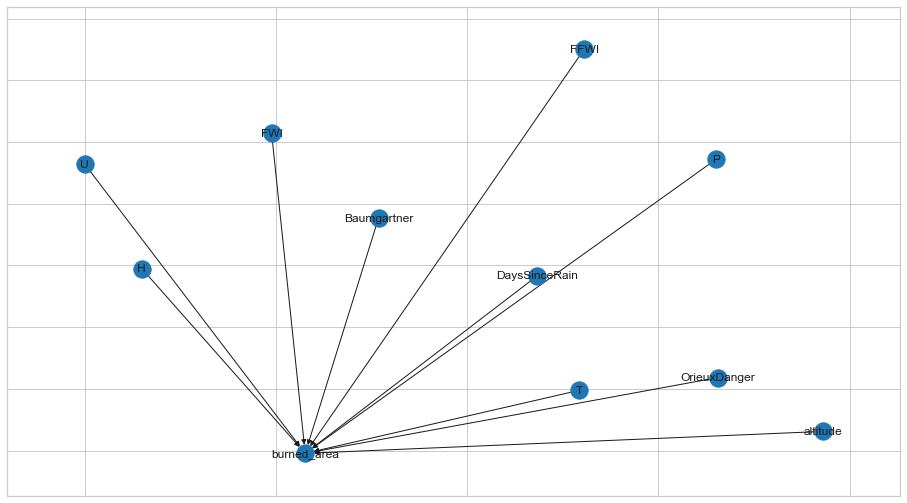

In [288]:
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
import networkx as nx
#sm.remove_edges_below_threshold(0.1)
fig, ax = plt.subplots()
nx.draw_networkx(sm, ax=ax)

In [289]:
from causalnex.network import BayesianNetwork

bn = BayesianNetwork(sm)


In [313]:
from causalnex.discretiser import Discretiser

df_BN = df_BA.copy().reset_index(drop=True)
for col in df_BN:
    print(col)
    df_BN[col] = Discretiser(method="quantile", num_buckets=4).fit_transform(df_BN[col].values)


T
H
U
P
DaysSinceRain
FFWI
Baumgartner
OrieuxDanger
FWI
altitude
burned_area


In [316]:
X_train, X_test = train_test_split(df_BN, shuffle=True, test_size=test_size, random_state=42)

In [321]:
bn = bn.fit_node_states(X_train)
bn = bn.fit_cpds(X_train, method="BayesianEstimator", bayes_prior="K2")
bn.cpds["T"]

,
T,
0,0.242574
1,0.244554
2,0.264356
3,0.248515


In [322]:
bn.predict(X_test, "burned_area")

,burned_area_prediction
561,3
101,0
51,0
63,0
1073,0
...,...
156,0
549,3
398,3
243,2


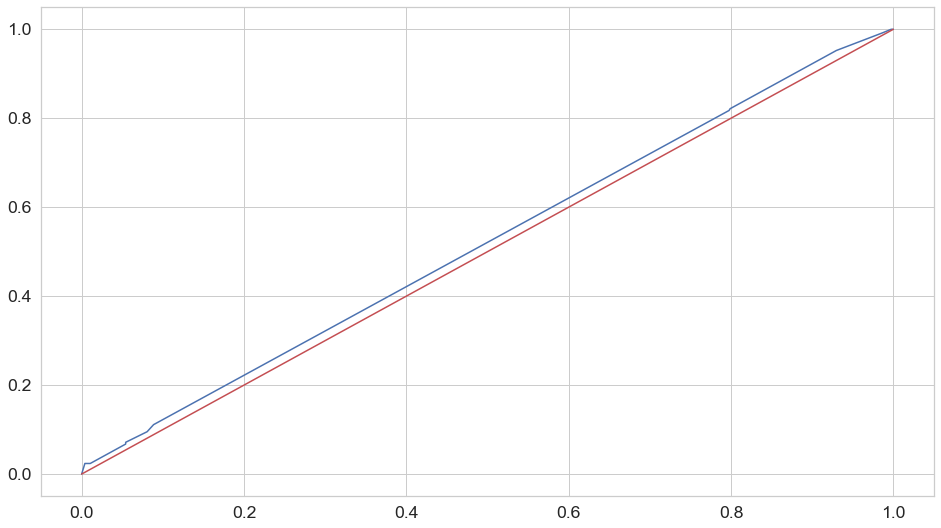

In [335]:
from causalnex.evaluation import roc_auc
roc, auc = roc_auc(bn, X_test, "burned_area")
plt.plot(np.array(roc)[:,0], np.array(roc)[:,1])
plt.plot((0,1), (0,1), "r-")

In [84]:
param_grid = {"max_depth": range(1,4), "n_estimators": range(50,300, 50), "reg_alpha": [0.1, 1, 10], "learning_rate": [0.01, 0.05, 0.1, 0.2]}
#mlflow.log_params(kwargs)
clf_cv = GridSearchCV(estimator = XGBRegressor(n_jobs=5, use_label_encoder=False), scoring = "r2", param_grid = param_grid, n_jobs=5, cv=3)
clf_cv.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=5,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, use_label_encode

In [85]:
clf_cv.best_params_

{'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 50, 'reg_alpha': 10}

-- Train set performance -- 
(MAE) Mean absolute error:  0.872
(RMSE) Root mean squared error:  1.015
(R2) R2-score:  0.1949
-- Test set performance -- 
(MAE) Mean absolute error:  0.9565
(RMSE) Root mean squared error:  1.1303
(R2) R2-score:  0.0469


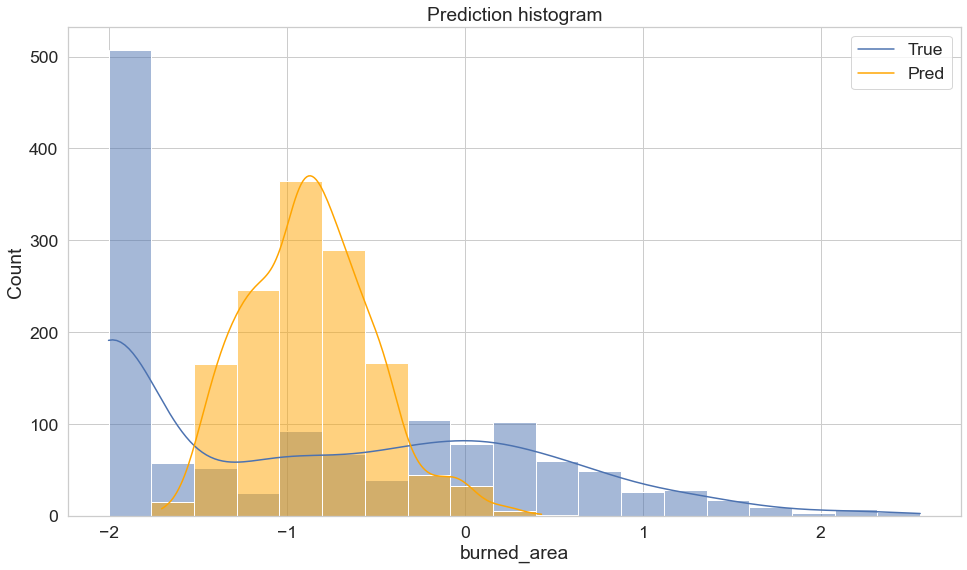

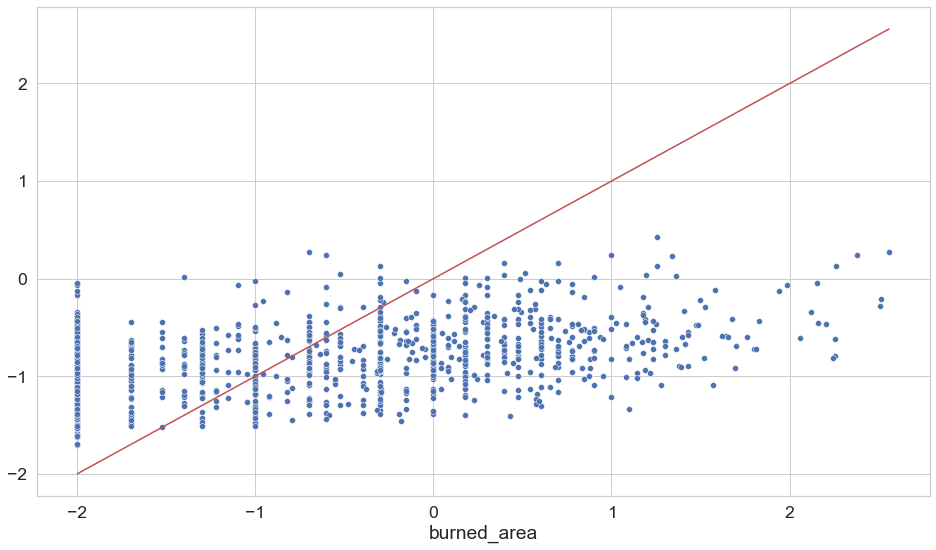

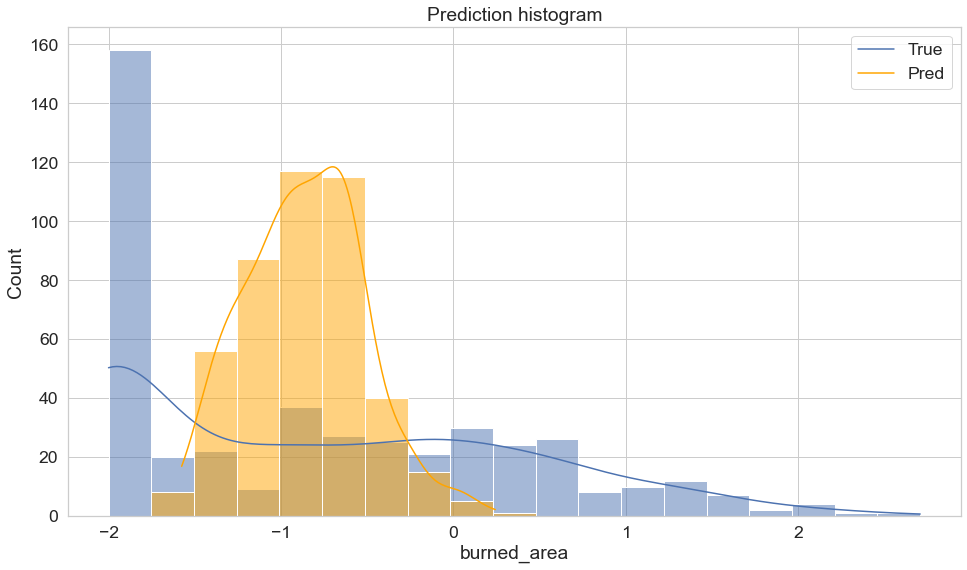

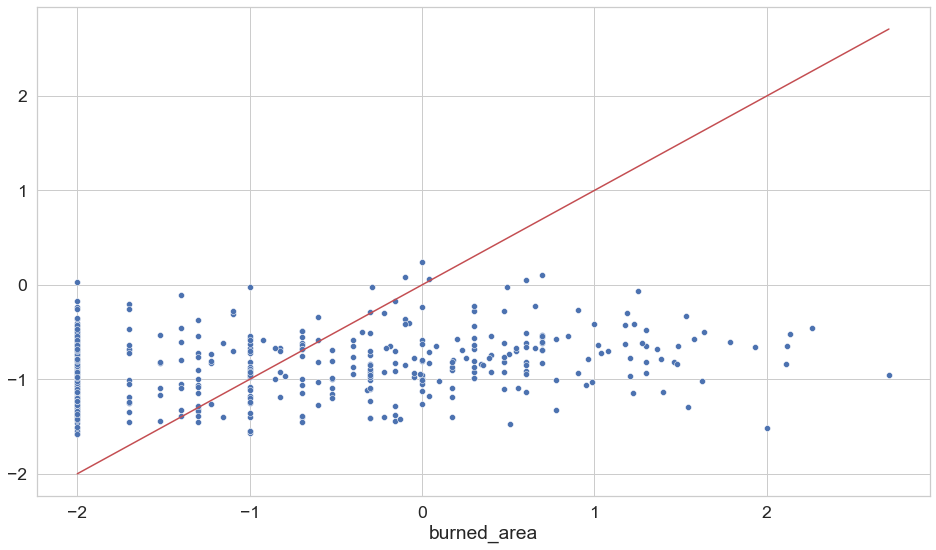

In [86]:
print("-- Train set performance -- ")
mae, rmse, r2 = evaluate_regression(y_train, clf_cv.predict(X_train))
mlflow.log_metrics({"mae_train": mae, "rmse_train": rmse, "r2_train": r2})
print("-- Test set performance -- ")
mae, rmse, r2 = evaluate_regression(y_test, clf_cv.predict(X_test))
mlflow.log_metrics({"mae_test": mae, "rmse_test": rmse, "r2_test": r2})
mlflow.end_run()

<AxesSubplot:xlabel='importance', ylabel='feature'>

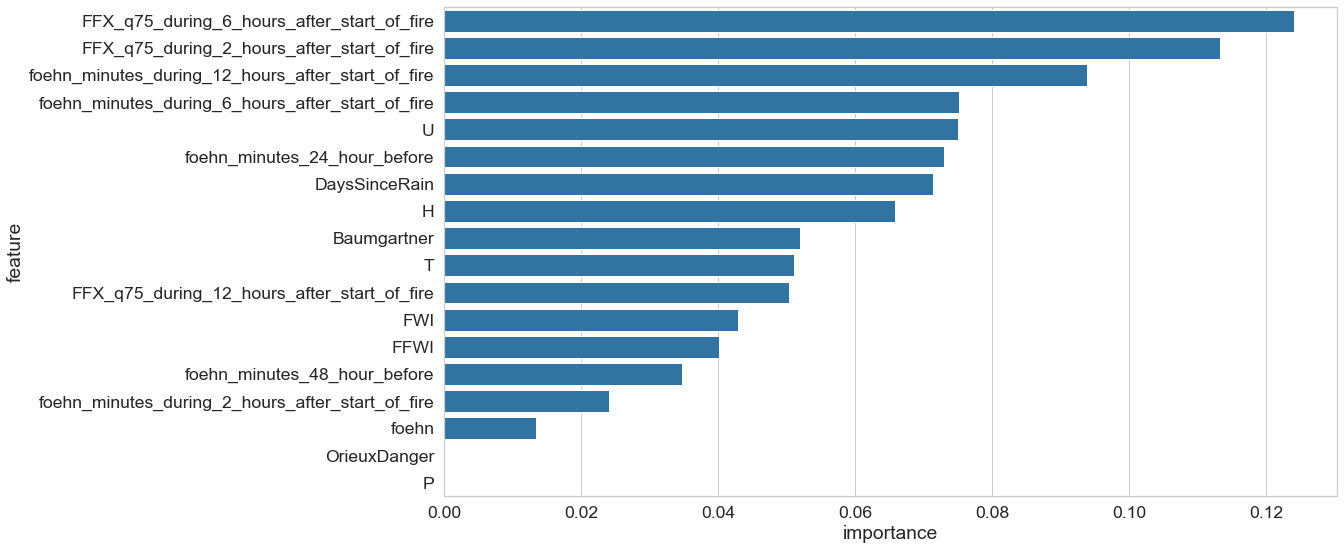

In [87]:
imp = pd.DataFrame({"feature": final_features, "importance": clf_cv.best_estimator_.feature_importances_}).sort_values(by="importance", ascending=False)
sns.barplot(y=imp["feature"], x=imp["importance"], color="tab:blue")

## Fire pred model

In [30]:
# Merge fire indice and fire data on each date and station (abbreviation). Remove duplicated dates and stations (when there is more than one fire per day at a station)
df_OC = pd.merge(df_indices[indice_cols_to_keep], df_fires[["date", "abbreviation","burned_area"]], on = ["date", "abbreviation"], how="left")
df_OC = df_OC.loc[~df_OC.duplicated(subset=["date", "abbreviation"], keep="first"),:]
df_OC = df_OC.loc[df_OC["region"] == "southern_switzerland", :].reset_index(drop=True)

# Define a fire day when there is a fire for a given day and station
df_OC.loc[df_OC["burned_area"].notnull(), "fire"] = 1
df_OC.loc[df_OC["burned_area"].isnull(), "fire"] = 0 
#df_OC["burned_area"] = np.log10(df_OC["burned_area"])

In [31]:
df_foehn = context.catalog.load("foehn_data_prepared")
df_foehn = df_foehn.set_index("date")

2021-06-17 11:27:51,123 - kedro.io.data_catalog - INFO - Loading data from `foehn_data_prepared` (CSVDataSet)...


In [34]:
df_OC_foehn = df_OC.copy()
for window_length, time in [("24h", 12), ("18h", 0), ("12h", 6), ("12h", 18), ("6h", 18), ("6h", 12)]:
    df_agg = (df_foehn.filter(regex="_foehn").rolling(window_length).sum()*10/60).loc[(df_foehn.index.time == datetime.time(time,0)), :].melt(var_name="abbreviation", value_name=f"foehn_hours_{window_length}_before_{time}00", ignore_index=False)
    df_agg["abbreviation"]  = df_agg["abbreviation"].str.split("_").str[0]
    df_agg = df_agg.reset_index()
    df_agg["date"] = df_agg["date"].dt.date.astype(np.datetime64)
    df_OC_foehn = pd.merge(df_OC_foehn, df_agg, on = ["date", "abbreviation"], how="left")

# Investigate FWI the day before

PIO
LUG
OTL


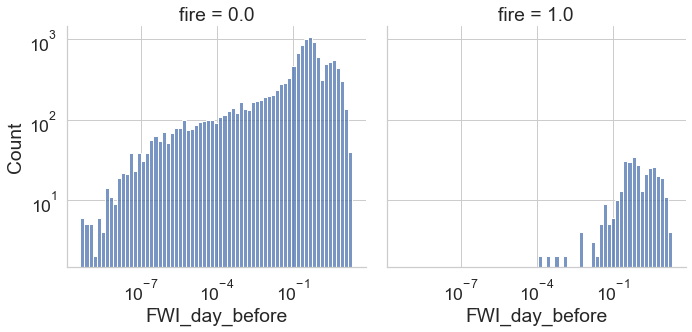

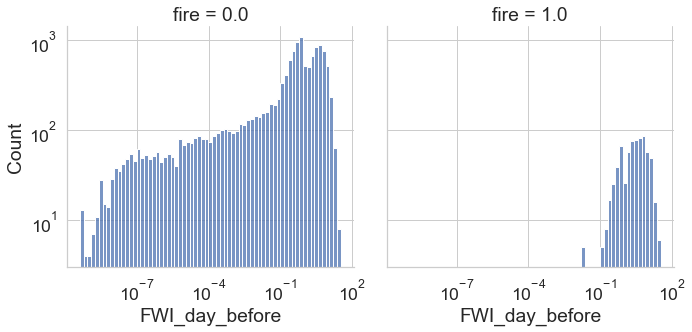

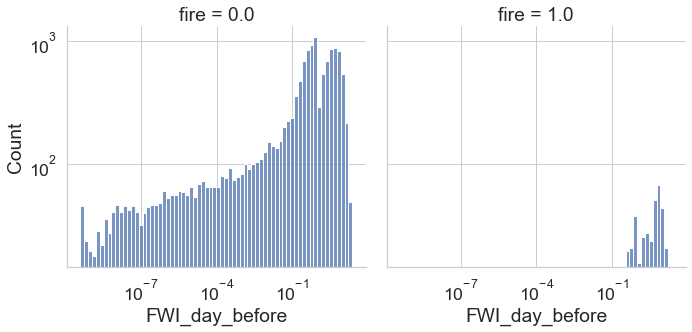

In [39]:
rows_list = []

percentiles = np.arange(0,1,0.5)
for station in (set(df_OC_foehn["abbreviation"].unique())- {"ROB"}):
    print(station)
    df_local = df_OC_foehn.loc[df_OC_foehn["abbreviation"]==station, :].set_index("date", verify_integrity=True)
    df_local["FWI_day_before"] = df_local["FWI"].shift(periods=1, freq="D")
    sns.displot(x="FWI_day_before",  data=df_local, col="fire", kind="hist", log_scale=(True,True))
    #fires_FWI = df_local.loc[df_local["fire"]==1, "FWI_day_before"]
    
#     for i, p in enumerate(percentiles):
#         df_local.loc[df_local["FWI_day_before"]>fires_FWI.quantile(p), "dry_day"] = i
        
#     for foehn_variable  in ["foehn_hours_6h_before_1800", "foehn_hours_12h_before_1800"]:
#         df_local_foehn = df_local.dropna(subset=["burned_area", foehn_variable]).reset_index(drop=True)
#         #sns.lmplot(x=foehn_variable, y="burned_area", data=df_local_foehn, col="dry_day")
#         plt.figure()
#         df_local_foehn.loc[:, f"{foehn_variable}_cut"] = pd.cut(df_local_foehn.loc[:, foehn_variable], bins=[-0.001, 0.001, df_local_foehn[foehn_variable].max()])
#         g = sns.boxplot(hue=f"{foehn_variable}_cut", y="burned_area", data=df_local_foehn, x="dry_day")
#         g.set_yscale("log")
#         plt.grid(True, which="both", ls="--", c='gray', alpha=0.5)
        

#         for i, p in enumerate(percentiles):
#             df_dry = df_local_foehn.loc[df_local_foehn["dry_day"]==i, :]
#             slope_dict = {"station": station, "foehn_variable": foehn_variable, "N_fires": len(df_dry.index)}
#             slope, intercept, _, _, _  = scipy.stats.linregress(x=df_dry[foehn_variable], y=df_dry["burned_area"])
#             slope_dict["percentile"] = str(int(p*100))
#             slope_dict["slope"] = slope

#             rows_list.append(slope_dict)

# df_slopes = pd.DataFrame(rows_list)
# display(df_slopes)
# sns.scatterplot(data=df_slopes, x="percentile", y="slope", hue="station")

# Train occurence model

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from scipy.integrate import simps
import datetime
import scipy
import statsmodels.formula.api as smf

In [216]:
X_train, X_test, y_train, y_test = train_test_split(df_OC_foehn.drop(columns=["fire", "burned_area", "region", "date", "abbreviation"]), df_OC_foehn["fire"], test_size=0.2, random_state=42)

<AxesSubplot:>

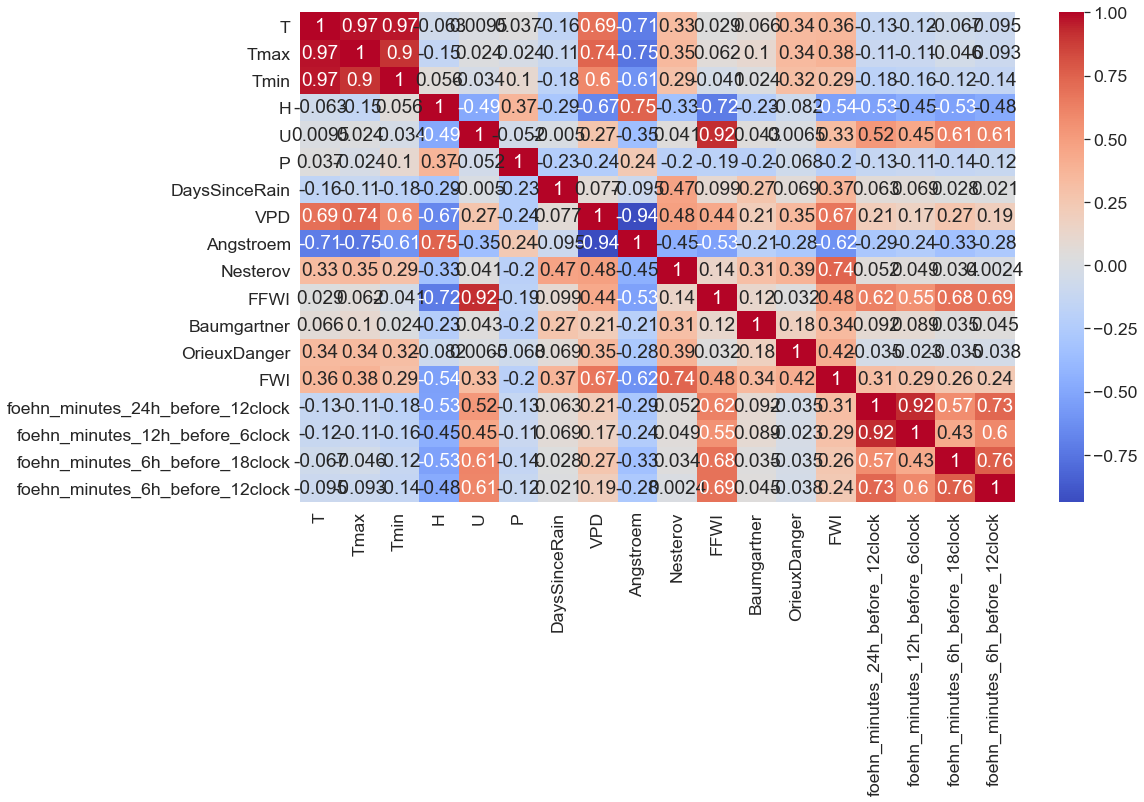

In [217]:
sns.heatmap(X_train.corr(), cmap="coolwarm", annot=True)

In [218]:
param_grid = {"max_depth": range(2,6), "n_estimators": range(200,400, 50), "learning_rate": [0.01, 0.05, 0.1, 0.2]}
#mlflow.log_params(kwargs)
clf_cv = GridSearchCV(estimator=XGBClassifier(n_jobs=5, use_label_encoder=False), scoring="roc_auc", param_grid=param_grid, n_jobs=5, cv=3)
clf_cv.fit(X_train, y_train)
clf_cv.best_params_

KeyboardInterrupt: 

In [ ]:
def calc_AUCbg(y_true, y_proba):
    thresholds = np.linspace(1,0,5000)
    positives = (y_true == 1)
    
    c_dict = {}
    TP_list = []
    bg_list = []
    for c in thresholds:
        y_pred = (c <= y_proba)
        
        TP = (y_true[positives] == y_pred[positives]).sum()
        bg = y_pred.sum()
        
        c_dict[c] = (bg, TP)
        bg_list.append(bg)
        TP_list.append(TP)
    
    bg_list = np.array(bg_list)/len(y_proba)
    TP_list = np.array(TP_list)/positives.sum()
    
    prevalance = positives.sum()/len(y_proba)
    print("Prevalance: ", prevalance)
    print("AUGbg maximum: ", 1-prevalance/2)
    plt.plot(bg_list, TP_list, "x")
    plt.xlabel("Background proportion")
    plt.ylabel("True positive rate")
    
    index = np.unique(bg_list, return_index=True)[1]
    return simps(y=TP_list[index], x=bg_list[index])

calc_AUCbg(y_true=y_test, y_proba=clf_cv.predict_proba(X_test)[:,1])

--- Train set ---
AUROC:  0.8677086445305673
Log. loss:  0.10488486506277732
Best threshold with F1-score:  0.10824114
Precision:  0.23550295857988165
Recall:  0.3422184006878762
F1:  0.2790045566070803
--- Test set ---
AUROC:  0.8088924002436796
Log. loss:  0.12714585807905118
Best threshold with F1-score:  0.08559348
Precision:  0.16142270861833105
Recall:  0.35119047619047616
F1:  0.2211808809746954


0.08559348

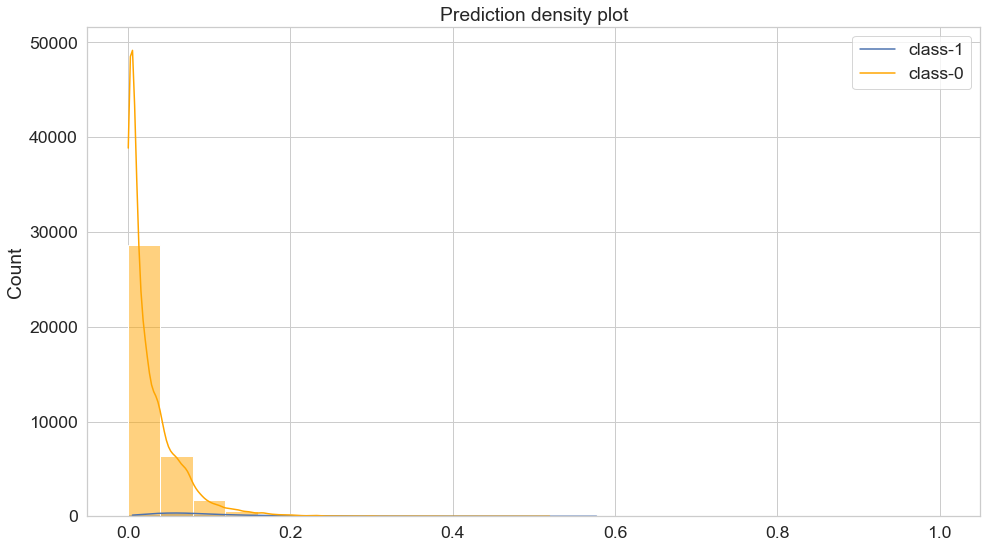

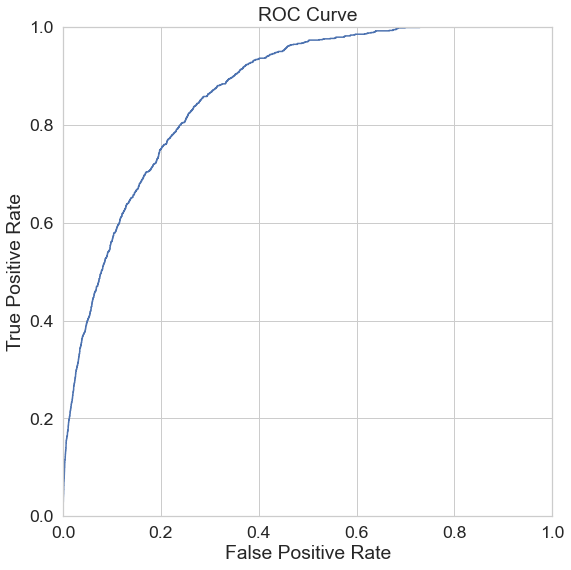

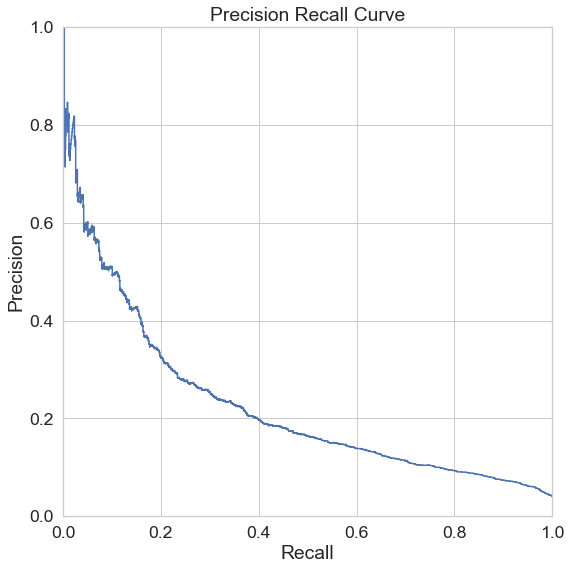

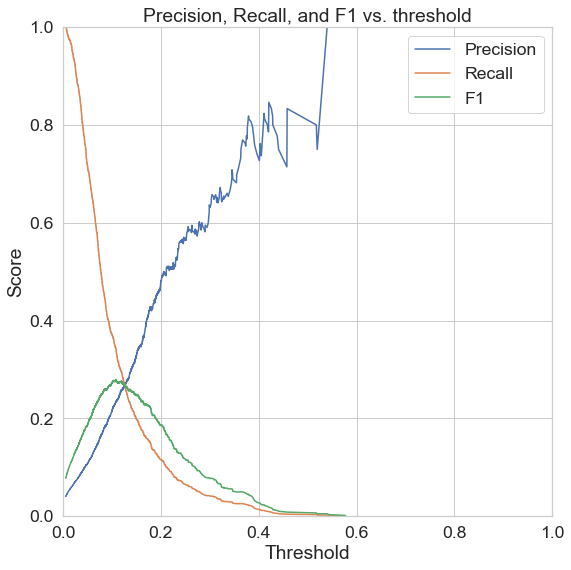

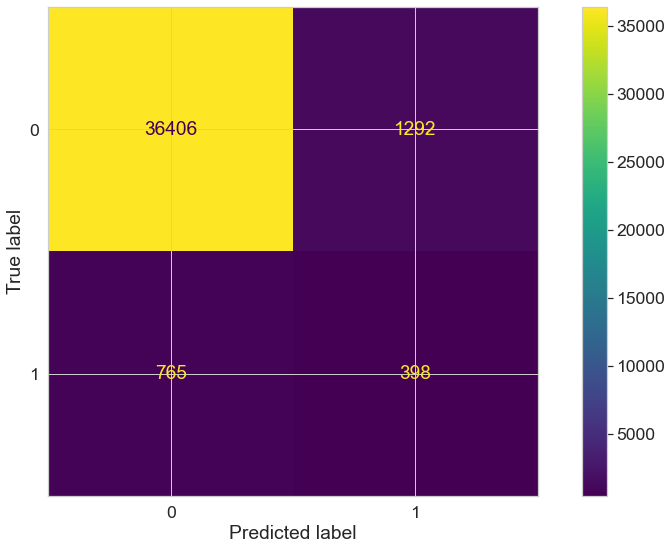

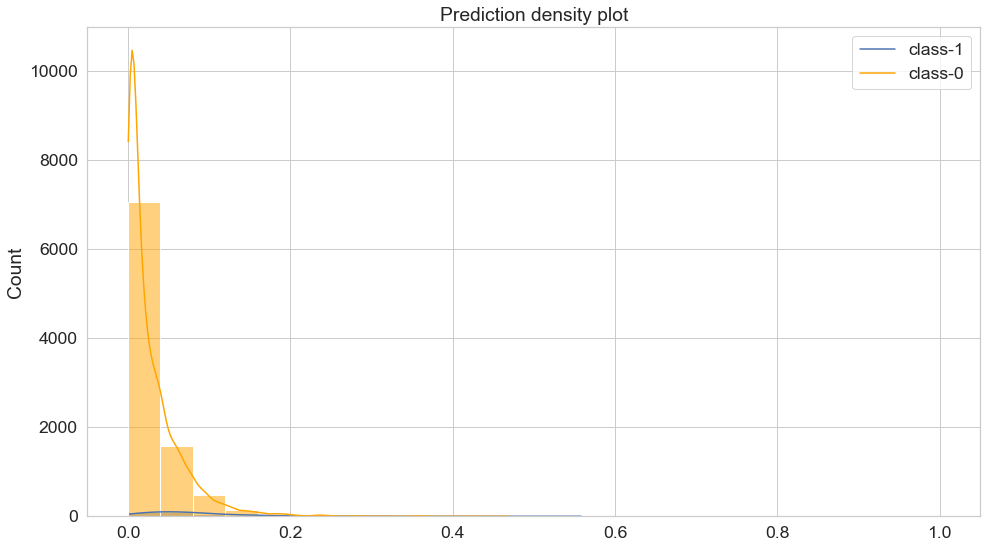

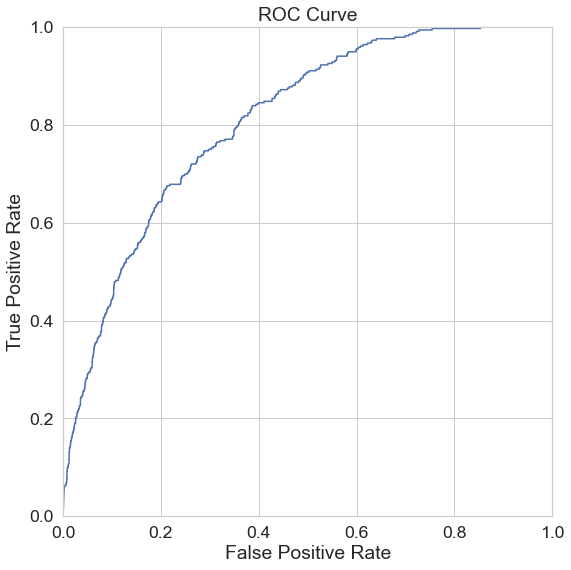

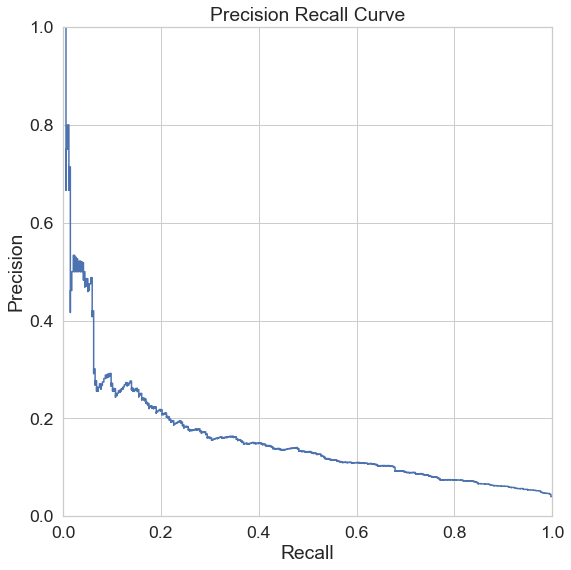

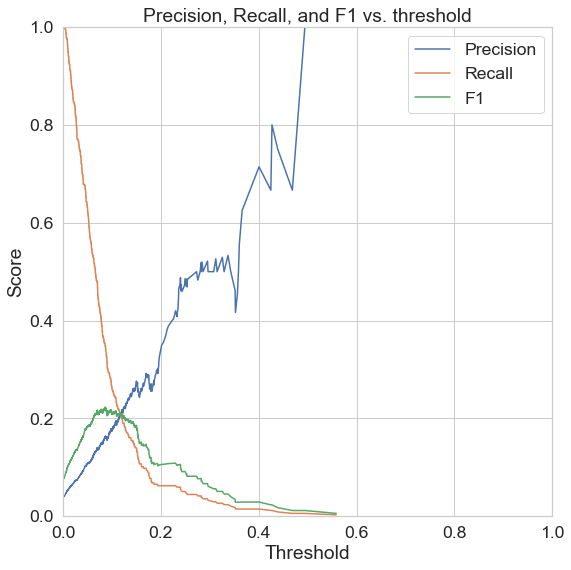

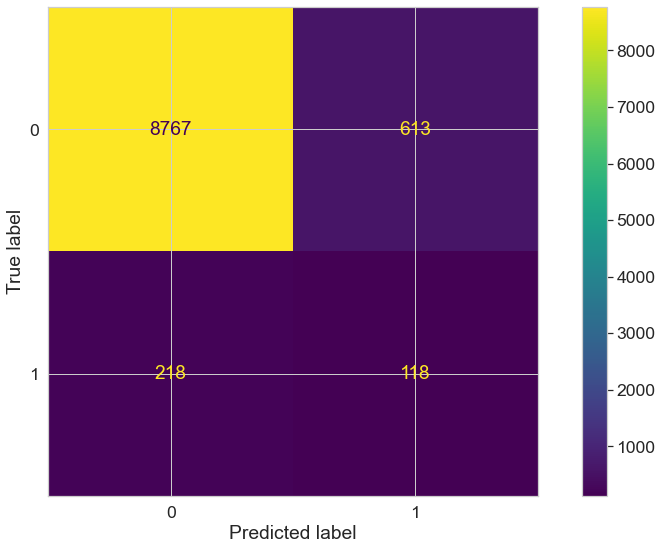

In [202]:
print("--- Train set ---")
evaluate_binary_classification(y_true=y_train, y_proba=clf_cv.predict_proba(X_train)[:,1])
print("--- Test set ---")
evaluate_binary_classification(y_true=y_test, y_proba=clf_cv.predict_proba(X_test)[:,1])

<AxesSubplot:xlabel='importance', ylabel='feature'>

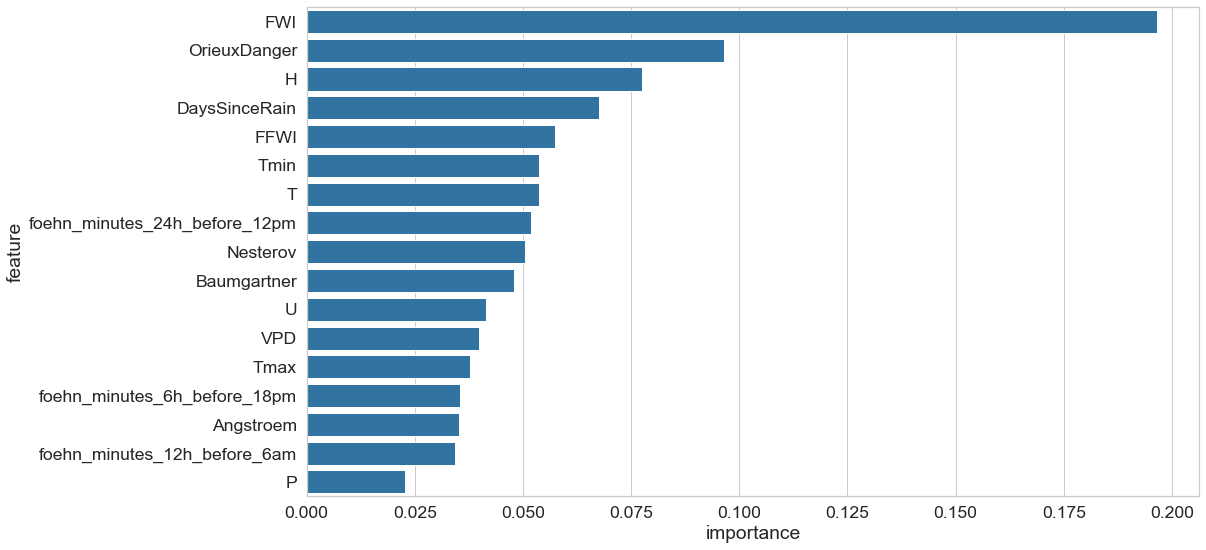

In [203]:
imp = pd.DataFrame({"feature": X_train.columns, "importance": clf_cv.best_estimator_.feature_importances_}).sort_values(by="importance", ascending=False)
sns.barplot(y=imp["feature"], x=imp["importance"], color="tab:blue")